# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 10)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3887 / G_loss : 0.6809
- D(x) : 0.4987 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5062
[1/100][1/14]
- D_loss : 1.3923 / G_loss : 0.6742
- D(x) : 0.4995 / D(G(z1)) : 0.5024 / D(G(z2)) : 0.5096
[1/100][2/14]
- D_loss : 1.3949 / G_loss : 0.6697
- D(x) : 0.5004 / D(G(z1)) : 0.5046 / D(G(z2)) : 0.5119
[1/100][3/14]
- D_loss : 1.3982 / G_loss : 0.6653
- D(x) : 0.5011 / D(G(z1)) : 0.5069 / D(G(z2)) : 0.5141
[1/100][4/14]
- D_loss : 1.4034 / G_loss : 0.6611
- D(x) : 0.5005 / D(G(z1)) : 0.5090 / D(G(z2)) : 0.5163
[1/100][5/14]
- D_loss : 1.4086 / G_loss : 0.6550
- D(x) : 0.5011 / D(G(z1)) : 0.5120 / D(G(z2)) : 0.5195
[1/100][6/14]
- D_loss : 1.4125 / G_loss : 0.6488
- D(x) : 0.5027 / D(G(z1)) : 0.5155 / D(G(z2)) : 0.5227
[1/100][7/14]
- D_loss : 1.4155 / G_loss : 0.6439
- D(x) : 0.5039 / D(G(z1)) : 0.5181 / D(G(z2)) : 0.5252
[1/100][8/14]
- D_loss : 1.4210 / G_loss : 0.6392
- D(x) : 0.5041 / D(G(z1)) : 0.5209 / D(G(z2)) : 0.5277
[1/100][9/14]
- D_loss : 1.4268 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.5107 / G_loss : 0.5491
- D(x) : 0.5221 / D(G(z1)) : 0.5771 / D(G(z2)) : 0.5775
[6/100][9/14]
- D_loss : 1.5092 / G_loss : 0.5498
- D(x) : 0.5222 / D(G(z1)) : 0.5765 / D(G(z2)) : 0.5771
[6/100][10/14]
- D_loss : 1.5065 / G_loss : 0.5495
- D(x) : 0.5236 / D(G(z1)) : 0.5766 / D(G(z2)) : 0.5773
[6/100][11/14]
- D_loss : 1.5089 / G_loss : 0.5481
- D(x) : 0.5232 / D(G(z1)) : 0.5772 / D(G(z2)) : 0.5781
[6/100][12/14]
- D_loss : 1.5098 / G_loss : 0.5474
- D(x) : 0.5234 / D(G(z1)) : 0.5778 / D(G(z2)) : 0.5785
[6/100][13/14]
- D_loss : 1.5108 / G_loss : 0.5472
- D(x) : 0.5235 / D(G(z1)) : 0.5783 / D(G(z2)) : 0.5786
[7/100][0/14]
- D_loss : 1.5127 / G_loss : 0.5483
- D(x) : 0.5219 / D(G(z1)) : 0.5778 / D(G(z2)) : 0.5779
[7/100][1/14]
- D_loss : 1.5058 / G_loss : 0.5488
- D(x) : 0.5255 / D(G(z1)) : 0.5778 / D(G(z2)) : 0.5776
[7/100][2/14]
- D_loss : 1.5068 / G_loss : 0.5504
- D(x) : 0.5240 / D(G(z1)) : 0.5770 / D(G(z2)) : 0.5767
[7/100][3/14]
- D_loss : 1.5055 / G_loss :

[12/100][1/14]
- D_loss : 1.5082 / G_loss : 0.5436
- D(x) : 0.5273 / D(G(z1)) : 0.5802 / D(G(z2)) : 0.5807
[12/100][2/14]
- D_loss : 1.5073 / G_loss : 0.5426
- D(x) : 0.5283 / D(G(z1)) : 0.5806 / D(G(z2)) : 0.5812
[12/100][3/14]
- D_loss : 1.5078 / G_loss : 0.5414
- D(x) : 0.5286 / D(G(z1)) : 0.5810 / D(G(z2)) : 0.5819
[12/100][4/14]
- D_loss : 1.5105 / G_loss : 0.5400
- D(x) : 0.5280 / D(G(z1)) : 0.5817 / D(G(z2)) : 0.5828
[12/100][5/14]
- D_loss : 1.5162 / G_loss : 0.5386
- D(x) : 0.5264 / D(G(z1)) : 0.5828 / D(G(z2)) : 0.5835
[12/100][6/14]
- D_loss : 1.5147 / G_loss : 0.5378
- D(x) : 0.5279 / D(G(z1)) : 0.5834 / D(G(z2)) : 0.5840
[12/100][7/14]
- D_loss : 1.5168 / G_loss : 0.5367
- D(x) : 0.5273 / D(G(z1)) : 0.5838 / D(G(z2)) : 0.5847
[12/100][8/14]
- D_loss : 1.5218 / G_loss : 0.5366
- D(x) : 0.5257 / D(G(z1)) : 0.5845 / D(G(z2)) : 0.5848
[12/100][9/14]
- D_loss : 1.5165 / G_loss : 0.5370
- D(x) : 0.5283 / D(G(z1)) : 0.5844 / D(G(z2)) : 0.5845
[12/100][10/14]
- D_loss : 1.5206 / G

[17/100][8/14]
- D_loss : 1.5432 / G_loss : 0.5222
- D(x) : 0.5243 / D(G(z1)) : 0.5922 / D(G(z2)) : 0.5932
[17/100][9/14]
- D_loss : 1.5344 / G_loss : 0.5239
- D(x) : 0.5273 / D(G(z1)) : 0.5910 / D(G(z2)) : 0.5922
[17/100][10/14]
- D_loss : 1.5329 / G_loss : 0.5234
- D(x) : 0.5291 / D(G(z1)) : 0.5917 / D(G(z2)) : 0.5925
[17/100][11/14]
- D_loss : 1.5384 / G_loss : 0.5238
- D(x) : 0.5256 / D(G(z1)) : 0.5913 / D(G(z2)) : 0.5923
[17/100][12/14]
- D_loss : 1.5336 / G_loss : 0.5246
- D(x) : 0.5275 / D(G(z1)) : 0.5908 / D(G(z2)) : 0.5918
[17/100][13/14]
- D_loss : 1.5441 / G_loss : 0.5244
- D(x) : 0.5222 / D(G(z1)) : 0.5911 / D(G(z2)) : 0.5919
[18/100][0/14]
- D_loss : 1.5375 / G_loss : 0.5249
- D(x) : 0.5256 / D(G(z1)) : 0.5909 / D(G(z2)) : 0.5916
[18/100][1/14]
- D_loss : 1.5373 / G_loss : 0.5256
- D(x) : 0.5251 / D(G(z1)) : 0.5905 / D(G(z2)) : 0.5912
[18/100][2/14]
- D_loss : 1.5353 / G_loss : 0.5255
- D(x) : 0.5260 / D(G(z1)) : 0.5903 / D(G(z2)) : 0.5913
[18/100][3/14]
- D_loss : 1.5320 

[23/100][1/14]
- D_loss : 1.5111 / G_loss : 0.5440
- D(x) : 0.5259 / D(G(z1)) : 0.5803 / D(G(z2)) : 0.5804
[23/100][2/14]
- D_loss : 1.5052 / G_loss : 0.5447
- D(x) : 0.5285 / D(G(z1)) : 0.5799 / D(G(z2)) : 0.5800
[23/100][3/14]
- D_loss : 1.5105 / G_loss : 0.5452
- D(x) : 0.5256 / D(G(z1)) : 0.5796 / D(G(z2)) : 0.5797
[23/100][4/14]
- D_loss : 1.5111 / G_loss : 0.5465
- D(x) : 0.5242 / D(G(z1)) : 0.5789 / D(G(z2)) : 0.5790
[23/100][5/14]
- D_loss : 1.5046 / G_loss : 0.5472
- D(x) : 0.5270 / D(G(z1)) : 0.5783 / D(G(z2)) : 0.5786
[23/100][6/14]
- D_loss : 1.5074 / G_loss : 0.5479
- D(x) : 0.5249 / D(G(z1)) : 0.5778 / D(G(z2)) : 0.5782
[23/100][7/14]
- D_loss : 1.5070 / G_loss : 0.5484
- D(x) : 0.5247 / D(G(z1)) : 0.5776 / D(G(z2)) : 0.5779
[23/100][8/14]
- D_loss : 1.5061 / G_loss : 0.5485
- D(x) : 0.5250 / D(G(z1)) : 0.5775 / D(G(z2)) : 0.5778
[23/100][9/14]
- D_loss : 1.5040 / G_loss : 0.5482
- D(x) : 0.5261 / D(G(z1)) : 0.5774 / D(G(z2)) : 0.5780
[23/100][10/14]
- D_loss : 1.5017 / G

[28/100][8/14]
- D_loss : 1.4678 / G_loss : 0.5775
- D(x) : 0.5259 / D(G(z1)) : 0.5617 / D(G(z2)) : 0.5613
[28/100][9/14]
- D_loss : 1.4700 / G_loss : 0.5784
- D(x) : 0.5240 / D(G(z1)) : 0.5610 / D(G(z2)) : 0.5608
[28/100][10/14]
- D_loss : 1.4640 / G_loss : 0.5796
- D(x) : 0.5260 / D(G(z1)) : 0.5600 / D(G(z2)) : 0.5601
[28/100][11/14]
- D_loss : 1.4576 / G_loss : 0.5797
- D(x) : 0.5292 / D(G(z1)) : 0.5599 / D(G(z2)) : 0.5601
[28/100][12/14]
- D_loss : 1.4550 / G_loss : 0.5789
- D(x) : 0.5307 / D(G(z1)) : 0.5599 / D(G(z2)) : 0.5605
[28/100][13/14]
- D_loss : 1.4634 / G_loss : 0.5787
- D(x) : 0.5263 / D(G(z1)) : 0.5600 / D(G(z2)) : 0.5606
[29/100][0/14]
- D_loss : 1.4645 / G_loss : 0.5783
- D(x) : 0.5262 / D(G(z1)) : 0.5604 / D(G(z2)) : 0.5609
[29/100][1/14]
- D_loss : 1.4627 / G_loss : 0.5783
- D(x) : 0.5272 / D(G(z1)) : 0.5605 / D(G(z2)) : 0.5608
[29/100][2/14]
- D_loss : 1.4712 / G_loss : 0.5778
- D(x) : 0.5231 / D(G(z1)) : 0.5608 / D(G(z2)) : 0.5611
[29/100][3/14]
- D_loss : 1.4711 

[34/100][1/14]
- D_loss : 1.4343 / G_loss : 0.6026
- D(x) : 0.5271 / D(G(z1)) : 0.5477 / D(G(z2)) : 0.5474
[34/100][2/14]
- D_loss : 1.4253 / G_loss : 0.6032
- D(x) : 0.5315 / D(G(z1)) : 0.5474 / D(G(z2)) : 0.5471
[34/100][3/14]
- D_loss : 1.4299 / G_loss : 0.6044
- D(x) : 0.5283 / D(G(z1)) : 0.5466 / D(G(z2)) : 0.5464
[34/100][4/14]
- D_loss : 1.4313 / G_loss : 0.6047
- D(x) : 0.5272 / D(G(z1)) : 0.5464 / D(G(z2)) : 0.5462
[34/100][5/14]
- D_loss : 1.4289 / G_loss : 0.6049
- D(x) : 0.5279 / D(G(z1)) : 0.5459 / D(G(z2)) : 0.5461
[34/100][6/14]
- D_loss : 1.4361 / G_loss : 0.6050
- D(x) : 0.5244 / D(G(z1)) : 0.5461 / D(G(z2)) : 0.5461
[34/100][7/14]
- D_loss : 1.4375 / G_loss : 0.6055
- D(x) : 0.5234 / D(G(z1)) : 0.5459 / D(G(z2)) : 0.5458
[34/100][8/14]
- D_loss : 1.4357 / G_loss : 0.6068
- D(x) : 0.5238 / D(G(z1)) : 0.5454 / D(G(z2)) : 0.5451
[34/100][9/14]
- D_loss : 1.4299 / G_loss : 0.6080
- D(x) : 0.5263 / D(G(z1)) : 0.5450 / D(G(z2)) : 0.5444
[34/100][10/14]
- D_loss : 1.4259 / G

[39/100][8/14]
- D_loss : 1.4239 / G_loss : 0.6131
- D(x) : 0.5253 / D(G(z1)) : 0.5413 / D(G(z2)) : 0.5417
[39/100][9/14]
- D_loss : 1.4258 / G_loss : 0.6124
- D(x) : 0.5247 / D(G(z1)) : 0.5417 / D(G(z2)) : 0.5420
[39/100][10/14]
- D_loss : 1.4383 / G_loss : 0.6114
- D(x) : 0.5183 / D(G(z1)) : 0.5419 / D(G(z2)) : 0.5426
[39/100][11/14]
- D_loss : 1.4268 / G_loss : 0.6091
- D(x) : 0.5254 / D(G(z1)) : 0.5428 / D(G(z2)) : 0.5438
[39/100][12/14]
- D_loss : 1.4319 / G_loss : 0.6073
- D(x) : 0.5238 / D(G(z1)) : 0.5438 / D(G(z2)) : 0.5448
[39/100][13/14]
- D_loss : 1.4308 / G_loss : 0.6058
- D(x) : 0.5257 / D(G(z1)) : 0.5448 / D(G(z2)) : 0.5457
[40/100][0/14]
- D_loss : 1.4370 / G_loss : 0.6038
- D(x) : 0.5234 / D(G(z1)) : 0.5457 / D(G(z2)) : 0.5467
[40/100][1/14]
- D_loss : 1.4399 / G_loss : 0.6017
- D(x) : 0.5232 / D(G(z1)) : 0.5469 / D(G(z2)) : 0.5479
[40/100][2/14]
- D_loss : 1.4440 / G_loss : 0.6002
- D(x) : 0.5222 / D(G(z1)) : 0.5479 / D(G(z2)) : 0.5487
[40/100][3/14]
- D_loss : 1.4395 

[45/100][1/14]
- D_loss : 1.4134 / G_loss : 0.6505
- D(x) : 0.5094 / D(G(z1)) : 0.5222 / D(G(z2)) : 0.5218
[45/100][2/14]
- D_loss : 1.4116 / G_loss : 0.6510
- D(x) : 0.5100 / D(G(z1)) : 0.5219 / D(G(z2)) : 0.5215
[45/100][3/14]
- D_loss : 1.4009 / G_loss : 0.6512
- D(x) : 0.5152 / D(G(z1)) : 0.5216 / D(G(z2)) : 0.5214
[45/100][4/14]
- D_loss : 1.4163 / G_loss : 0.6505
- D(x) : 0.5074 / D(G(z1)) : 0.5217 / D(G(z2)) : 0.5218
[45/100][5/14]
- D_loss : 1.4039 / G_loss : 0.6501
- D(x) : 0.5138 / D(G(z1)) : 0.5218 / D(G(z2)) : 0.5220
[45/100][6/14]
- D_loss : 1.4008 / G_loss : 0.6501
- D(x) : 0.5157 / D(G(z1)) : 0.5220 / D(G(z2)) : 0.5220
[45/100][7/14]
- D_loss : 1.4097 / G_loss : 0.6495
- D(x) : 0.5112 / D(G(z1)) : 0.5222 / D(G(z2)) : 0.5223
[45/100][8/14]
- D_loss : 1.4086 / G_loss : 0.6484
- D(x) : 0.5121 / D(G(z1)) : 0.5224 / D(G(z2)) : 0.5229
[45/100][9/14]
- D_loss : 1.4122 / G_loss : 0.6465
- D(x) : 0.5110 / D(G(z1)) : 0.5231 / D(G(z2)) : 0.5239
[45/100][10/14]
- D_loss : 1.4151 / G

[50/100][8/14]
- D_loss : 1.4092 / G_loss : 0.6539
- D(x) : 0.5092 / D(G(z1)) : 0.5200 / D(G(z2)) : 0.5200
[50/100][9/14]
- D_loss : 1.4117 / G_loss : 0.6539
- D(x) : 0.5081 / D(G(z1)) : 0.5201 / D(G(z2)) : 0.5200
[50/100][10/14]
- D_loss : 1.4147 / G_loss : 0.6540
- D(x) : 0.5066 / D(G(z1)) : 0.5202 / D(G(z2)) : 0.5200
[50/100][11/14]
- D_loss : 1.4060 / G_loss : 0.6544
- D(x) : 0.5109 / D(G(z1)) : 0.5201 / D(G(z2)) : 0.5197
[50/100][12/14]
- D_loss : 1.4113 / G_loss : 0.6548
- D(x) : 0.5079 / D(G(z1)) : 0.5198 / D(G(z2)) : 0.5195
[50/100][13/14]
- D_loss : 1.4142 / G_loss : 0.6545
- D(x) : 0.5063 / D(G(z1)) : 0.5197 / D(G(z2)) : 0.5197
[51/100][0/14]
- D_loss : 1.4168 / G_loss : 0.6543
- D(x) : 0.5051 / D(G(z1)) : 0.5198 / D(G(z2)) : 0.5198
[51/100][1/14]
- D_loss : 1.4103 / G_loss : 0.6545
- D(x) : 0.5085 / D(G(z1)) : 0.5199 / D(G(z2)) : 0.5197
[51/100][2/14]
- D_loss : 1.4111 / G_loss : 0.6551
- D(x) : 0.5080 / D(G(z1)) : 0.5198 / D(G(z2)) : 0.5194
[51/100][3/14]
- D_loss : 1.4171 

[56/100][1/14]
- D_loss : 1.3998 / G_loss : 0.6818
- D(x) : 0.4998 / D(G(z1)) : 0.5065 / D(G(z2)) : 0.5057
[56/100][2/14]
- D_loss : 1.3894 / G_loss : 0.6833
- D(x) : 0.5043 / D(G(z1)) : 0.5057 / D(G(z2)) : 0.5049
[56/100][3/14]
- D_loss : 1.3902 / G_loss : 0.6848
- D(x) : 0.5031 / D(G(z1)) : 0.5049 / D(G(z2)) : 0.5042
[56/100][4/14]
- D_loss : 1.3994 / G_loss : 0.6857
- D(x) : 0.4977 / D(G(z1)) : 0.5042 / D(G(z2)) : 0.5038
[56/100][5/14]
- D_loss : 1.3753 / G_loss : 0.6862
- D(x) : 0.5095 / D(G(z1)) : 0.5038 / D(G(z2)) : 0.5035
[56/100][6/14]
- D_loss : 1.3847 / G_loss : 0.6867
- D(x) : 0.5044 / D(G(z1)) : 0.5035 / D(G(z2)) : 0.5033
[56/100][7/14]
- D_loss : 1.3916 / G_loss : 0.6871
- D(x) : 0.5008 / D(G(z1)) : 0.5033 / D(G(z2)) : 0.5030
[56/100][8/14]
- D_loss : 1.3827 / G_loss : 0.6875
- D(x) : 0.5049 / D(G(z1)) : 0.5030 / D(G(z2)) : 0.5028
[56/100][9/14]
- D_loss : 1.3823 / G_loss : 0.6874
- D(x) : 0.5049 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5029
[56/100][10/14]
- D_loss : 1.3856 / G

[61/100][8/14]
- D_loss : 1.3808 / G_loss : 0.6847
- D(x) : 0.5079 / D(G(z1)) : 0.5049 / D(G(z2)) : 0.5042
[61/100][9/14]
- D_loss : 1.3837 / G_loss : 0.6863
- D(x) : 0.5056 / D(G(z1)) : 0.5042 / D(G(z2)) : 0.5034
[61/100][10/14]
- D_loss : 1.3768 / G_loss : 0.6877
- D(x) : 0.5084 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5027
[61/100][11/14]
- D_loss : 1.3777 / G_loss : 0.6893
- D(x) : 0.5071 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5019
[61/100][12/14]
- D_loss : 1.3813 / G_loss : 0.6909
- D(x) : 0.5045 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5011
[61/100][13/14]
- D_loss : 1.3715 / G_loss : 0.6928
- D(x) : 0.5087 / D(G(z1)) : 0.5011 / D(G(z2)) : 0.5002
[62/100][0/14]
- D_loss : 1.3788 / G_loss : 0.6948
- D(x) : 0.5040 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.4992
[62/100][1/14]
- D_loss : 1.3691 / G_loss : 0.6967
- D(x) : 0.5079 / D(G(z1)) : 0.4991 / D(G(z2)) : 0.4982
[62/100][2/14]
- D_loss : 1.3760 / G_loss : 0.6985
- D(x) : 0.5035 / D(G(z1)) : 0.4982 / D(G(z2)) : 0.4973
[62/100][3/14]
- D_loss : 1.3619 

[67/100][1/14]
- D_loss : 1.3499 / G_loss : 0.7217
- D(x) : 0.5052 / D(G(z1)) : 0.4868 / D(G(z2)) : 0.4859
[67/100][2/14]
- D_loss : 1.3513 / G_loss : 0.7236
- D(x) : 0.5038 / D(G(z1)) : 0.4859 / D(G(z2)) : 0.4850
[67/100][3/14]
- D_loss : 1.3444 / G_loss : 0.7249
- D(x) : 0.5064 / D(G(z1)) : 0.4851 / D(G(z2)) : 0.4844
[67/100][4/14]
- D_loss : 1.3415 / G_loss : 0.7252
- D(x) : 0.5071 / D(G(z1)) : 0.4843 / D(G(z2)) : 0.4843
[67/100][5/14]
- D_loss : 1.3318 / G_loss : 0.7260
- D(x) : 0.5119 / D(G(z1)) : 0.4842 / D(G(z2)) : 0.4839
[67/100][6/14]
- D_loss : 1.3485 / G_loss : 0.7274
- D(x) : 0.5031 / D(G(z1)) : 0.4838 / D(G(z2)) : 0.4831
[67/100][7/14]
- D_loss : 1.3392 / G_loss : 0.7274
- D(x) : 0.5071 / D(G(z1)) : 0.4831 / D(G(z2)) : 0.4831
[67/100][8/14]
- D_loss : 1.3414 / G_loss : 0.7286
- D(x) : 0.5060 / D(G(z1)) : 0.4832 / D(G(z2)) : 0.4826
[67/100][9/14]
- D_loss : 1.3293 / G_loss : 0.7300
- D(x) : 0.5116 / D(G(z1)) : 0.4827 / D(G(z2)) : 0.4819
[67/100][10/14]
- D_loss : 1.3330 / G

[72/100][8/14]
- D_loss : 1.3030 / G_loss : 0.7250
- D(x) : 0.5268 / D(G(z1)) : 0.4840 / D(G(z2)) : 0.4843
[72/100][9/14]
- D_loss : 1.3002 / G_loss : 0.7252
- D(x) : 0.5284 / D(G(z1)) : 0.4841 / D(G(z2)) : 0.4842
[72/100][10/14]
- D_loss : 1.3084 / G_loss : 0.7257
- D(x) : 0.5240 / D(G(z1)) : 0.4840 / D(G(z2)) : 0.4840
[72/100][11/14]
- D_loss : 1.3018 / G_loss : 0.7261
- D(x) : 0.5272 / D(G(z1)) : 0.4838 / D(G(z2)) : 0.4838
[72/100][12/14]
- D_loss : 1.3037 / G_loss : 0.7276
- D(x) : 0.5259 / D(G(z1)) : 0.4835 / D(G(z2)) : 0.4830
[72/100][13/14]
- D_loss : 1.3042 / G_loss : 0.7269
- D(x) : 0.5254 / D(G(z1)) : 0.4831 / D(G(z2)) : 0.4834
[73/100][0/14]
- D_loss : 1.2988 / G_loss : 0.7277
- D(x) : 0.5281 / D(G(z1)) : 0.4831 / D(G(z2)) : 0.4830
[73/100][1/14]
- D_loss : 1.3003 / G_loss : 0.7274
- D(x) : 0.5270 / D(G(z1)) : 0.4828 / D(G(z2)) : 0.4832
[73/100][2/14]
- D_loss : 1.2985 / G_loss : 0.7287
- D(x) : 0.5283 / D(G(z1)) : 0.4830 / D(G(z2)) : 0.4825
[73/100][3/14]
- D_loss : 1.3035 

[78/100][1/14]
- D_loss : 1.2745 / G_loss : 0.7193
- D(x) : 0.5433 / D(G(z1)) : 0.4848 / D(G(z2)) : 0.4871
[78/100][2/14]
- D_loss : 1.2792 / G_loss : 0.7109
- D(x) : 0.5436 / D(G(z1)) : 0.4877 / D(G(z2)) : 0.4912
[78/100][3/14]
- D_loss : 1.2801 / G_loss : 0.6979
- D(x) : 0.5479 / D(G(z1)) : 0.4922 / D(G(z2)) : 0.4976
[78/100][4/14]
- D_loss : 1.3002 / G_loss : 0.6854
- D(x) : 0.5437 / D(G(z1)) : 0.4985 / D(G(z2)) : 0.5039
[78/100][5/14]
- D_loss : 1.3194 / G_loss : 0.6727
- D(x) : 0.5402 / D(G(z1)) : 0.5048 / D(G(z2)) : 0.5103
[78/100][6/14]
- D_loss : 1.3213 / G_loss : 0.6653
- D(x) : 0.5466 / D(G(z1)) : 0.5113 / D(G(z2)) : 0.5141
[78/100][7/14]
- D_loss : 1.3271 / G_loss : 0.6630
- D(x) : 0.5472 / D(G(z1)) : 0.5147 / D(G(z2)) : 0.5153
[78/100][8/14]
- D_loss : 1.3378 / G_loss : 0.6619
- D(x) : 0.5422 / D(G(z1)) : 0.5158 / D(G(z2)) : 0.5159
[78/100][9/14]
- D_loss : 1.3324 / G_loss : 0.6622
- D(x) : 0.5460 / D(G(z1)) : 0.5164 / D(G(z2)) : 0.5157
[78/100][10/14]
- D_loss : 1.3438 / G

[83/100][8/14]
- D_loss : 1.3411 / G_loss : 0.7153
- D(x) : 0.5142 / D(G(z1)) : 0.4911 / D(G(z2)) : 0.4890
[83/100][9/14]
- D_loss : 1.3405 / G_loss : 0.7194
- D(x) : 0.5124 / D(G(z1)) : 0.4890 / D(G(z2)) : 0.4870
[83/100][10/14]
- D_loss : 1.3442 / G_loss : 0.7227
- D(x) : 0.5087 / D(G(z1)) : 0.4870 / D(G(z2)) : 0.4854
[83/100][11/14]
- D_loss : 1.3225 / G_loss : 0.7253
- D(x) : 0.5180 / D(G(z1)) : 0.4855 / D(G(z2)) : 0.4842
[83/100][12/14]
- D_loss : 1.3299 / G_loss : 0.7270
- D(x) : 0.5130 / D(G(z1)) : 0.4842 / D(G(z2)) : 0.4834
[83/100][13/14]
- D_loss : 1.3230 / G_loss : 0.7256
- D(x) : 0.5157 / D(G(z1)) : 0.4833 / D(G(z2)) : 0.4840
[84/100][0/14]
- D_loss : 1.3173 / G_loss : 0.7043
- D(x) : 0.5196 / D(G(z1)) : 0.4844 / D(G(z2)) : 0.4945
[84/100][1/14]
- D_loss : 1.3390 / G_loss : 0.6836
- D(x) : 0.5193 / D(G(z1)) : 0.4951 / D(G(z2)) : 0.5048
[84/100][2/14]
- D_loss : 1.3619 / G_loss : 0.6755
- D(x) : 0.5177 / D(G(z1)) : 0.5050 / D(G(z2)) : 0.5089
[84/100][3/14]
- D_loss : 1.3875 

[89/100][1/14]
- D_loss : 1.4116 / G_loss : 0.6613
- D(x) : 0.5025 / D(G(z1)) : 0.5144 / D(G(z2)) : 0.5164
[89/100][2/14]
- D_loss : 1.4171 / G_loss : 0.6602
- D(x) : 0.5012 / D(G(z1)) : 0.5158 / D(G(z2)) : 0.5170
[89/100][3/14]
- D_loss : 1.4167 / G_loss : 0.6607
- D(x) : 0.5008 / D(G(z1)) : 0.5153 / D(G(z2)) : 0.5167
[89/100][4/14]
- D_loss : 1.4092 / G_loss : 0.6621
- D(x) : 0.5040 / D(G(z1)) : 0.5147 / D(G(z2)) : 0.5160
[89/100][5/14]
- D_loss : 1.4089 / G_loss : 0.6615
- D(x) : 0.5041 / D(G(z1)) : 0.5146 / D(G(z2)) : 0.5163
[89/100][6/14]
- D_loss : 1.4132 / G_loss : 0.6618
- D(x) : 0.5018 / D(G(z1)) : 0.5145 / D(G(z2)) : 0.5162
[89/100][7/14]
- D_loss : 1.4149 / G_loss : 0.6635
- D(x) : 0.5010 / D(G(z1)) : 0.5145 / D(G(z2)) : 0.5153
[89/100][8/14]
- D_loss : 1.4177 / G_loss : 0.6614
- D(x) : 0.5002 / D(G(z1)) : 0.5151 / D(G(z2)) : 0.5164
[89/100][9/14]
- D_loss : 1.4090 / G_loss : 0.6632
- D(x) : 0.5038 / D(G(z1)) : 0.5144 / D(G(z2)) : 0.5155
[89/100][10/14]
- D_loss : 1.4168 / G

[94/100][8/14]
- D_loss : 1.4103 / G_loss : 0.6851
- D(x) : 0.4916 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5042
[94/100][9/14]
- D_loss : 1.4102 / G_loss : 0.6867
- D(x) : 0.4910 / D(G(z1)) : 0.5024 / D(G(z2)) : 0.5034
[94/100][10/14]
- D_loss : 1.4044 / G_loss : 0.6867
- D(x) : 0.4936 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5035
[94/100][11/14]
- D_loss : 1.4039 / G_loss : 0.6885
- D(x) : 0.4932 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5025
[94/100][12/14]
- D_loss : 1.4142 / G_loss : 0.6863
- D(x) : 0.4896 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5036
[94/100][13/14]
- D_loss : 1.4032 / G_loss : 0.6872
- D(x) : 0.4936 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5032
[95/100][0/14]
- D_loss : 1.4035 / G_loss : 0.6882
- D(x) : 0.4932 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5027
[95/100][1/14]
- D_loss : 1.4067 / G_loss : 0.6861
- D(x) : 0.4931 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5038
[95/100][2/14]
- D_loss : 1.4182 / G_loss : 0.6874
- D(x) : 0.4864 / D(G(z1)) : 0.5017 / D(G(z2)) : 0.5031
[95/100][3/14]
- D_loss : 1.4058 

[100/100][1/14]
- D_loss : 1.4077 / G_loss : 0.6916
- D(x) : 0.4889 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.5009
[100/100][2/14]
- D_loss : 1.4056 / G_loss : 0.6904
- D(x) : 0.4908 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5015
[100/100][3/14]
- D_loss : 1.4092 / G_loss : 0.6901
- D(x) : 0.4888 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5016
[100/100][4/14]
- D_loss : 1.4132 / G_loss : 0.6896
- D(x) : 0.4873 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5019
[100/100][5/14]
- D_loss : 1.4033 / G_loss : 0.6906
- D(x) : 0.4915 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5014
[100/100][6/14]
- D_loss : 1.4067 / G_loss : 0.6909
- D(x) : 0.4898 / D(G(z1)) : 0.4996 / D(G(z2)) : 0.5012
[100/100][7/14]
- D_loss : 1.4067 / G_loss : 0.6907
- D(x) : 0.4894 / D(G(z1)) : 0.4993 / D(G(z2)) : 0.5013
[100/100][8/14]
- D_loss : 1.4072 / G_loss : 0.6901
- D(x) : 0.4897 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5016
[100/100][9/14]
- D_loss : 1.4078 / G_loss : 0.6889
- D(x) : 0.4905 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5022
[100/100][10/14]
- D_loss : 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

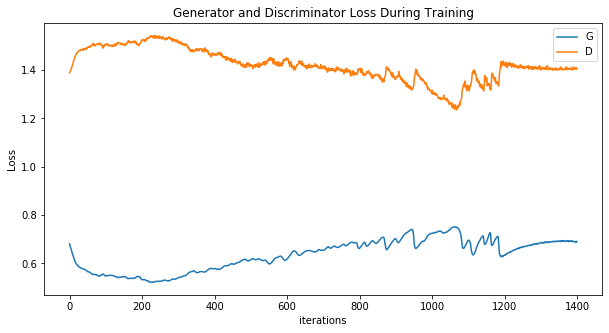

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

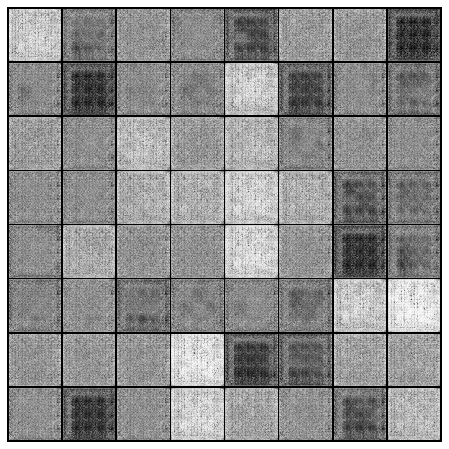

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1516.5963  Sum_of_z : -2.5330
[200]	 Ano_loss : 1433.4802  Sum_of_z : 5.5604
[400]	 Ano_loss : 1422.0607  Sum_of_z : 2.0800
picture  2
[0]	 Ano_loss : 1257.5912  Sum_of_z : 2.1564
[200]	 Ano_loss : 1156.0447  Sum_of_z : -0.5840
[400]	 Ano_loss : 1139.4658  Sum_of_z : -1.0196
picture  3
[0]	 Ano_loss : 1959.3141  Sum_of_z : -1.0207
[200]	 Ano_loss : 1925.9395  Sum_of_z : -7.4713
[400]	 Ano_loss : 1920.5800  Sum_of_z : -11.2929
picture  4
[0]	 Ano_loss : 1206.9387  Sum_of_z : -11.2658
[200]	 Ano_loss : 1154.8812  Sum_of_z : -9.4299
[400]	 Ano_loss : 1148.0927  Sum_of_z : -9.1229
picture  5
[0]	 Ano_loss : 2285.9045  Sum_of_z : -9.0955
[200]	 Ano_loss : 2272.9072  Sum_of_z : -12.1062
[400]	 Ano_loss : 2270.5085  Sum_of_z : -13.1522
picture  6
[0]	 Ano_loss : 1205.2172  Sum_of_z : -13.1098
[200]	 Ano_loss : 1190.9707  Sum_of_z : -15.7399
[400]	 Ano_loss : 1190.5033  Sum_of_z : -16.9748
picture  7
[0]	 Ano_loss : 1129.1765  Sum_of_z : -17.0054
[200]	 Ano_loss : 11

---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

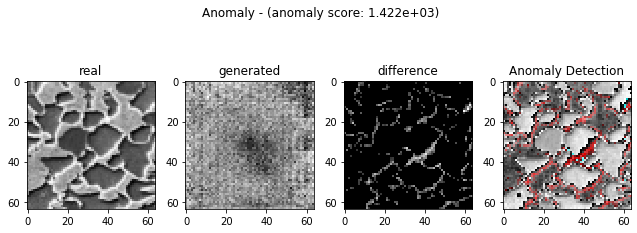

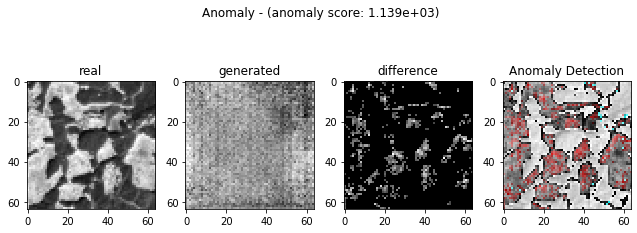

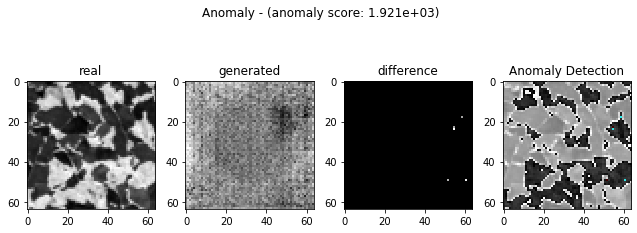

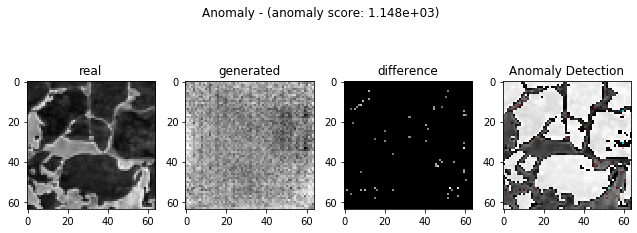

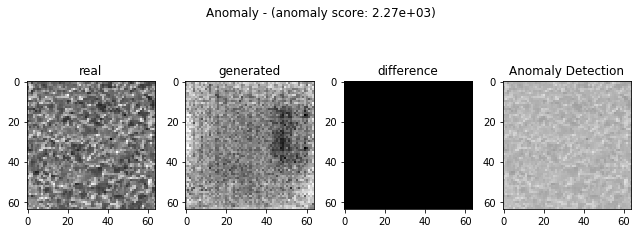

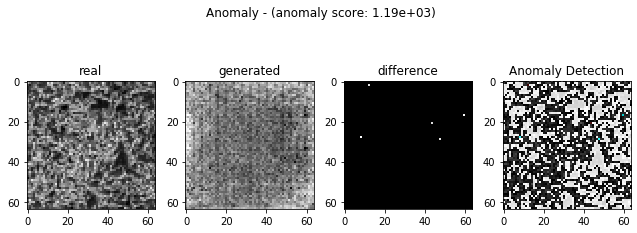

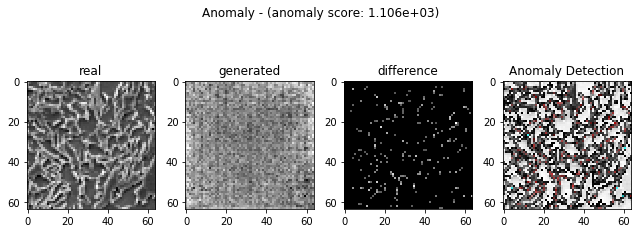

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.14160156 0.171875   0.0012207  0.01269531 0.         0.0012207
 0.05371094]


In [ ]:
print(sum(diff_fraction)/len(diff_fraction))

---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [ ]:
load_pretrained()

In [ ]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [ ]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [ ]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

In [ ]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)